In [ ]:
import torch
from torch import nn
from torchsummary import summary as summary_
from torch.nn import functional as F
import torch.nn.utils.prune as prune

## Model


In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        # input is 28x28
        # padding=2 for same padding
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        # feature map size is 14*14 by pooling
        # padding=2 for same padding
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        # feature map size is 7*7 by pooling
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*7*7)   # reshape Variable
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
model = MnistModel()

## Profiling: parameter

In [ ]:
summary_(model,(1,28,28),batch_size=10)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [10, 32, 28, 28]             832
            Conv2d-2           [10, 64, 14, 14]          51,264
            Linear-3                 [10, 1024]       3,212,288
            Linear-4                   [10, 10]          10,250
Total params: 3,274,634
Trainable params: 3,274,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 2.95
Params size (MB): 12.49
Estimated Total Size (MB): 15.47
----------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Profiler: torch-sensor
- reference: https://github.com/parrt/tensor-sensor


In [ ]:
!pip install tensor-sensor[torch]

In [ ]:
import torch
import tsensor
import sys
import numpy as np

W = np.array([[1, 2], [3, 4]])
b = np.array([9, 10]).reshape(2, 1)
x = np.array([4, 5]).reshape(2, 1)
h = np.array([1,2])

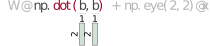

PyTorch says: shapes (2,1) and (2,1) not aligned: 1 (dim 1) != 2 (dim 0)

tsensor adds: Cause: np.dot(b,b) tensor arg b w/shape (2, 1), arg b w/shape (2, 1)


In [ ]:
try: # try is used just to catch the exception and extract the messages
    with tsensor.clarify():
        W @ np.dot(b,b) + np.eye(2,2)@x
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

In [ ]:
import tsensor
import torch
import sys


b = torch.tensor([9, 10])
_b = torch.tensor([9, 10]).reshape((2, 1))

In [ ]:
try: # try is used just to catch the exception and extract the messages
    with tsensor.clarify():
       torch.dot(b, b) 
except BaseException as e:
    msgs = e.args[0].split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

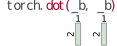

PyTorch says: 1D tensors expected, but got 2D and 2D tensors

tsensor adds: Cause: torch.dot(_b,_b) tensor arg _b w/shape [2, 1], arg _b w/shape [2, 1]


In [ ]:
try: # try is used just to catch the exception and extract the messages
    with tsensor.clarify():
       torch.dot(_b, _b) 
except BaseException as e:
    msgs = e.args[0].split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

## pytorch profiler

- reference: https://pytorch.org/tutorials/recipes/recipes/profiler.html

In [ ]:
import torch
import torchvision.models as models
import torch.autograd.profiler as profiler

In [ ]:
model = models.resnet18()
inputs = torch.randn(5, 3, 224, 224)

In [ ]:
with profiler.profile(record_shapes=True) as prof:
    with profiler.record_function("model_inference"):
        model(inputs)

In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference         2.20%      14.361ms        99.99%     652.923ms     652.923ms             1  
                     aten::conv2d         0.03%     208.229us        64.34%     420.113ms      21.006ms            20  
                aten::convolution         0.05%     319.874us        64.30%     419.905ms      20.995ms            20  
               aten::_convolution         0.09%     609.126us        64.25%     419.585ms      20.979ms            20  
         aten::mkldnn_convolution        64.06%     418.329ms        64.15%     418.903ms      20.945ms            20  
                 aten::batch_norm       

In [ ]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))


---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ---------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls                                   Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ---------------------------------------------  
                  model_inference         2.20%      14.361ms        99.99%     652.923ms     652.923ms             1                                             []  
                     aten::conv2d         0.01%      38.045us        15.00%      97.968ms      24.492ms             4  [[5, 64, 56, 56], [64, 64, 3, 3], [], [], [],  
                aten::convolution         0.01%      52.012us        15.00%      97.930ms      24.483ms             4  [[5, 64, 56, 56], [64, 64, 3, 3], [], [], [], 

In [ ]:
with profiler.profile(profile_memory=True, record_shapes=True) as prof:
    model(inputs)

print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                      aten::empty         0.12%     663.238us         0.12%     663.238us       5.349us      94.79 Mb      94.79 Mb           124  
                    aten::resize_         0.00%      14.337us         0.00%      14.337us       7.168us      11.48 Mb      11.48 Mb             2  
                      aten::addmm         0.08%     411.513us         0.08%     428.917us     428.917us      19.53 Kb      19.53 Kb             1  
              aten::empty_strided         0.00%       4.314us         0.00%       4.314us       4.314us         

In [ ]:
print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                      aten::empty         0.12%     663.238us         0.12%     663.238us       5.349us      94.79 Mb      94.79 Mb           124  
                 aten::batch_norm         0.03%     178.128us        26.99%     145.716ms       7.286ms      47.41 Mb           0 b            20  
     aten::_batch_norm_impl_index         0.04%     202.783us        26.96%     145.538ms       7.277ms      47.41 Mb           0 b            20  
          aten::native_batch_norm        17.60%      95.005ms        26.91%     145.255ms       7.263ms      47.

In [ ]:
with profiler.profile() as prof:
    with profiler.record_function("model_inference"):
        model(inputs)

prof.export_chrome_trace("/trace.json")

In [ ]:
prof.export_chrome_trace("/trace.json")

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
with profiler.profile() as prof:
    with profiler.record_function("model_inference"):
        model(inputs)

prof.export_chrome_trace("/content/gdrive/MyDrive/trace.json")